# Stock Predict Model

## Set Up

### Import Modules

In [165]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# For Graph
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

# Yahoo API
import yfinance as yf

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

### Configurations

In [166]:
device = 'cuda' if torch.cuda.is_available() else ('cpu' if torch.backends.mps.is_available() else 'cpu')
scaler = StandardScaler()
config = {
    'seed': 666999,
    'select_all': False,
    'valid_ratio': 0.2,
    'test_ratio': 0.2,
    'n_epochs': 5000,
    'learning_rate': 1e-5,
    'early_stop': 300,
    'save_path': './models/stock.ckpt',
    'data_loader': {
        'batch_size': 128,
        'pin_memory': True,
        'num_workers': 0,
        'shuffle': True
    }
}

### Utility Functions

In [167]:
def same_seed(seed):
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

def predict(test_loader, model, device):
    model.eval()
    result = {'features': [], 'preds': [], 'ans': []}
    for x, y in tqdm(test_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            result['features'].append(x.detach().cpu())
            result['preds'].append(pred.detach().cpu())
            result['ans'].append(y.detach().cpu())

    # Combination tensor
    result['features'] = torch.cat(result['features'], 0).numpy()
    result['preds'] = torch.cat(result['preds'], 0).numpy()
    result['ans'] = torch.cat(result['ans'], 0).numpy()

    predstack = np.column_stack((result['features'], result['preds']))
    targetstack = np.column_stack((result['features'], result['ans']))

    return np.column_stack((predstack[:, -1], targetstack[:, -1]))

def plot_error_rate(pred, target):
    '''Plot error rate.'''
    errors = (np.absolute(pred - target) / target) * 100
    plt.plot(errors, '-r')

    plt.xlabel('')
    plt.ylabel('Percentage')
    plt.title('Error Rate')

    plt.show()

def plot_pred(pred, target):
    '''Plot predict.'''
    plt.plot(pred, '-g', label='Prediction')
    plt.plot(target, '--r', label='Target')

    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title('Predictions')
    plt.legend()

    plt.show()

def plot_trend(pred, target):
    X = np.array(pred).reshape(-1, 1)
    y = np.array(target)

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    plt.scatter(pred, target, c='b', label='Data')
    plt.plot(pred, y_pred, c='r', label='Trend Line')

    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    plt.title('Trend')
    plt.legend()

    plt.show()

def tqdm_span(t):
    return f"[{t.format_interval(t.format_dict['elapsed'] * (t.format_dict['total'] or 0) / max(t.format_dict['n'], 1))}]"

def tqdm_count(t, step):
    step += 1
    return f"{step}/{t.format_dict['total']}", step


## Data

### Dataset

In [168]:
class Stock_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None, normalized=False, initscaler=True):
        # Normalized
        stack = np.column_stack((x, y))

        if (normalized):
            normalstack = scaler.fit_transform(stack) if initscaler else scaler.transform(stack)
            x = normalstack[:, :-1]
            y = y if y is None else normalstack[:, -1]

        self.y = y if y is None else torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

### DataLoader

In [169]:
def stock_dataloader(config, x, y=None, normalized=False, initscaler=True):
    ''' Generates a dataset, then is put into a dataloader. '''

    x = np.array(x)
    y = np.array(y) if y is not None else y

    dataset = Stock_Dataset(x, y, normalized, initscaler)
    dataloader = DataLoader(dataset, **config['data_loader'])

    return dataloader

### Feature Selection

In [170]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid, y_test = train_data[:,-1], valid_data[:,-1], test_data[:, -1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:, :-1], valid_data[:, :-1], test_data[:, :-1]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3] # TODO: Select suitable feature columns.

    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid, y_test

### Set Data

In [171]:
same_seed(config['seed'])

# re-index
index = ["Open", "High", "Low", "Adj Close", "Volume", "Close"]
raw_data = pd.DataFrame(yf.download('2330.TW', start='2000-01-01', end='2023-12-31'))
# raw_data.to_csv("raw.csv", index=False)
train_data, test_data = train_test_split(
    raw_data[index].values,
    test_size=config['test_ratio'],
    random_state=config['seed'],
    shuffle=False
)

train_data, valid_data = train_test_split(
    train_data,
    test_size=config['valid_ratio'],
    random_state=config['seed'],
    shuffle=True
)

# Print out the data size.
print(f"""train_data size: {train_data.shape}
valid_data size: {valid_data.shape}
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid, y_test = select_feat(train_data, valid_data, test_data, config['select_all'])

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

# Pytorch data loader loads pytorch dataset into batches.
train_loader = stock_dataloader(config, x_train, y_train)
valid_loader = stock_dataloader(config, x_valid, y_valid, initscaler=False)
test_loader = stock_dataloader(config, x_test, y_test, initscaler=False)

[*********************100%***********************]  1 of 1 completed
train_data size: (3737, 6)
valid_data size: (935, 6)
test_data size: (1169, 6)
number of features: 4


## Neural Network

### Model

In [172]:
class Stock_Model(nn.Module):
    def __init__(self, input_dim):
        super(Stock_Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)
        return x

### Training Loop

In [173]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7)

    writer = SummaryWriter()

    if not os.path.isdir('./models'):
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):

        train_step = 0
        valid_step = 0
        postfix = [{"Loss": 0, "Span": "", "Count": "", "Title": "Train Loss"}, {"Loss": 0, "Span": "", "Count": "", "Title": "Valid Loss"}]
        bar_format = "{l_bar}{bar}| {postfix[0][Count]} {postfix[0][Span]} {postfix[0][Title]} {postfix[0][Loss]:>2.4f}, {postfix[1][Count]} {postfix[1][Span]} {postfix[1][Title]} {postfix[1][Loss]:>2.4f}"

        # train
        model.train()
        loss_train_record = []

        # with torch.inference_mode():
        with tqdm(train_loader,
                bar_format=bar_format,
                desc=f'Epoch [{epoch+1}/{n_epochs}]',
                postfix=postfix,
                leave=False) as t:
            for x, y in t:
                optimizer.zero_grad()
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
                step += 1
                loss_train_record.append(loss.detach().item())
                mean_train_loss = sum(loss_train_record)/len(loss_train_record)
                
                t.postfix[0]["Loss"] = mean_train_loss
                t.postfix[0]["Span"] = tqdm_span(t)
                t.postfix[0]["Count"], train_step = tqdm_count(t, train_step)
                t.update()

        writer.add_scalar('Loss/train', mean_train_loss, step)

        # valid
        model.eval()
        loss_valid_record = []

        with tqdm(valid_loader,
                bar_format=bar_format,
                desc=f'Epoch [{epoch+1}/{n_epochs}]',
                postfix=postfix) as t:
            for x, y in t:
                x, y = x.to(device), y.to(device)
                with torch.no_grad():
                    pred = model(x)
                    loss = criterion(pred, y)
                    loss_valid_record.append(loss.item())
                    mean_valid_loss = sum(loss_valid_record)/len(loss_valid_record)

                    t.postfix[1]["Loss"] = mean_valid_loss
                    t.postfix[1]["Span"] = tqdm_span(t)
                    t.postfix[1]["Count"], valid_step = tqdm_count(t, valid_step)
                    t.update()

        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

## Training

In [174]:
model = Stock_Model(input_dim=x_train.shape[1]).to(device)
trainer(train_loader, valid_loader, model, config, device)

# with torch.profiler.profile(
#     activities=[torch.profiler.ProfilerActivity.CPU],
#     schedule = torch.profiler.schedule(
#         wait=0,
#         warmup=0,
#         active=1
#     ),
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
# ) as prof:
#     trainer(train_loader, valid_loader, model, config, device)
#     prof.step()

Epoch [1/5000]: 100%|██████████| 30/30 [00:00] Train Loss 10400.6660, 8/8 [00:00] Valid Loss 9705.3884


Saving model with loss 9705.388...


Epoch [2/5000]: 100%|██████████| 30/30 [00:00] Train Loss 10425.4820, 8/8 [00:00] Valid Loss 9552.7384


Saving model with loss 9552.738...


Epoch [3/5000]: 100%|██████████| 30/30 [00:00] Train Loss 10059.8313, 8/8 [00:00] Valid Loss 9426.3875


Saving model with loss 9426.387...


Epoch [4/5000]: 100%|██████████| 30/30 [00:00] Train Loss 9523.9278, 8/8 [00:00] Valid Loss 9222.3654


Saving model with loss 9222.365...


Epoch [5/5000]: 100%|██████████| 30/30 [00:00] Train Loss 9225.8902, 8/8 [00:00] Valid Loss 8407.8331


Saving model with loss 8407.833...


Epoch [6/5000]: 100%|██████████| 30/30 [00:00] Train Loss 8886.3972, 8/8 [00:00] Valid Loss 8053.2847


Saving model with loss 8053.285...


Epoch [7/5000]: 100%|██████████| 30/30 [00:00] Train Loss 8079.4297, 8/8 [00:00] Valid Loss 7512.3719


Saving model with loss 7512.372...


Epoch [8/5000]: 100%|██████████| 30/30 [00:00] Train Loss 7295.0171, 8/8 [00:00] Valid Loss 6559.1713


Saving model with loss 6559.171...


Epoch [9/5000]: 100%|██████████| 30/30 [00:00] Train Loss 6342.0432, 8/8 [00:00] Valid Loss 5749.6104


Saving model with loss 5749.610...


Epoch [10/5000]: 100%|██████████| 30/30 [00:00] Train Loss 5471.1229, 8/8 [00:00] Valid Loss 4703.4477


Saving model with loss 4703.448...


Epoch [11/5000]: 100%|██████████| 30/30 [00:00] Train Loss 4363.2392, 8/8 [00:00] Valid Loss 3872.8456


Saving model with loss 3872.846...


Epoch [12/5000]: 100%|██████████| 30/30 [00:00] Train Loss 3450.3305, 8/8 [00:00] Valid Loss 2893.2769


Saving model with loss 2893.277...


Epoch [13/5000]: 100%|██████████| 30/30 [00:00] Train Loss 2575.3078, 8/8 [00:00] Valid Loss 1979.2136


Saving model with loss 1979.214...


Epoch [14/5000]: 100%|██████████| 30/30 [00:00] Train Loss 1894.1071, 8/8 [00:00] Valid Loss 1378.9044


Saving model with loss 1378.904...


Epoch [16/5000]: 100%|██████████| 30/30 [00:00] Train Loss 1135.5789, 8/8 [00:00] Valid Loss 1096.7527


Saving model with loss 1096.753...


Epoch [17/5000]: 100%|██████████| 30/30 [00:00] Train Loss 777.7519, 8/8 [00:00] Valid Loss 650.5065


Saving model with loss 650.507...


Epoch [18/5000]: 100%|██████████| 30/30 [00:00] Train Loss 539.5544, 8/8 [00:00] Valid Loss 444.6776


Saving model with loss 444.678...


Epoch [19/5000]: 100%|██████████| 30/30 [00:00] Train Loss 397.7164, 8/8 [00:00] Valid Loss 210.4356


Saving model with loss 210.436...


Epoch [20/5000]: 100%|██████████| 30/30 [00:00] Train Loss 293.4051, 8/8 [00:00] Valid Loss 198.5546


Saving model with loss 198.555...


Epoch [22/5000]: 100%|██████████| 30/30 [00:00] Train Loss 128.6172, 8/8 [00:00] Valid Loss 68.0892


Saving model with loss 68.089...


Epoch [24/5000]: 100%|██████████| 30/30 [00:00] Train Loss 90.1490, 8/8 [00:00] Valid Loss 31.1948


Saving model with loss 31.195...


Epoch [29/5000]: 100%|██████████| 30/30 [00:00] Train Loss 58.3295, 8/8 [00:00] Valid Loss 18.8265


Saving model with loss 18.826...


Epoch [32/5000]: 100%|██████████| 30/30 [00:00] Train Loss 57.8959, 8/8 [00:00] Valid Loss 11.8734


Saving model with loss 11.873...


Epoch [42/5000]: 100%|██████████| 30/30 [00:00] Train Loss 44.0264, 8/8 [00:00] Valid Loss 8.9877


Saving model with loss 8.988...


Epoch [45/5000]: 100%|██████████| 30/30 [00:00] Train Loss 44.8433, 8/8 [00:00] Valid Loss 5.0692


Saving model with loss 5.069...


Epoch [52/5000]: 100%|██████████| 30/30 [00:00] Train Loss 53.3010, 8/8 [00:00] Valid Loss 4.2313


Saving model with loss 4.231...


Epoch [61/5000]: 100%|██████████| 30/30 [00:00] Train Loss 35.7506, 8/8 [00:00] Valid Loss 3.1755


Saving model with loss 3.176...


Epoch [80/5000]: 100%|██████████| 30/30 [00:00] Train Loss 54.7540, 8/8 [00:00] Valid Loss 2.9818


Saving model with loss 2.982...


Epoch [82/5000]: 100%|██████████| 30/30 [00:00] Train Loss 36.5825, 8/8 [00:00] Valid Loss 1.8971


Saving model with loss 1.897...


Epoch [96/5000]: 100%|██████████| 30/30 [00:00] Train Loss 26.5964, 8/8 [00:00] Valid Loss 1.1777


Saving model with loss 1.178...


Epoch [137/5000]: 100%|██████████| 30/30 [00:00] Train Loss 35.9896, 8/8 [00:00] Valid Loss 1.1418


Saving model with loss 1.142...


Epoch [273/5000]: 100%|██████████| 30/30 [00:00] Train Loss 28.5930, 8/8 [00:00] Valid Loss 0.8512


Saving model with loss 0.851...


Epoch [291/5000]: 100%|██████████| 30/30 [00:00] Train Loss 26.1042, 8/8 [00:00] Valid Loss 0.8133


Saving model with loss 0.813...


Epoch [308/5000]: 100%|██████████| 30/30 [00:00] Train Loss 36.3872, 8/8 [00:00] Valid Loss 0.7545


Saving model with loss 0.755...


Epoch [604/5000]: 100%|██████████| 30/30 [00:00] Train Loss 22.4921, 8/8 [00:00] Valid Loss 0.6894


Saving model with loss 0.689...


Epoch [904/5000]: 100%|██████████| 30/30 [00:00] Train Loss 34.6333, 8/8 [00:00] Valid Loss 4.2115


Model is not improving, so we halt the training session.


In [175]:
# print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))


In [176]:
%tensorboard --logdir=./log/

UsageError: Line magic function `%tensorboard` not found.


## Plot learning curves with tensorboard

In [177]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

## Testing

100%|██████████| 10/10 [00:00<00:00, 643.87it/s]


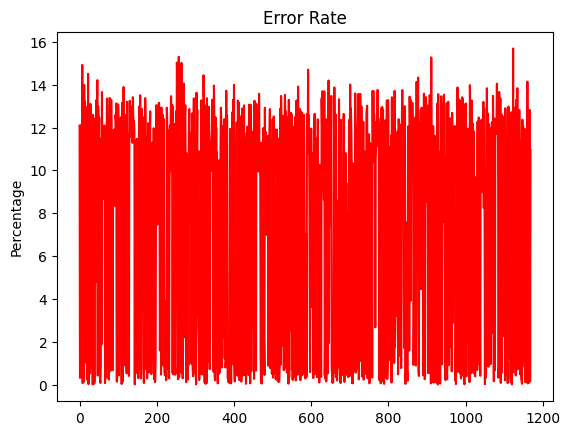

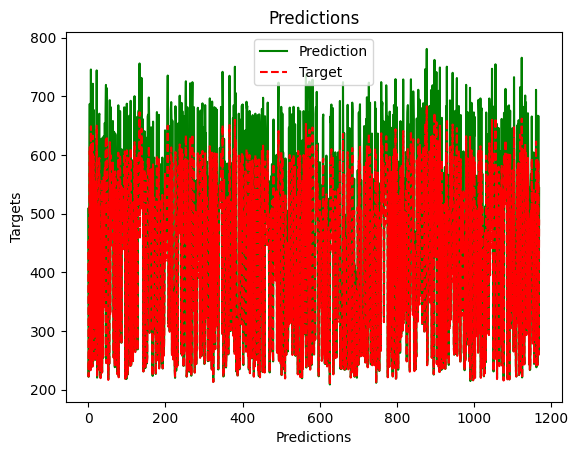

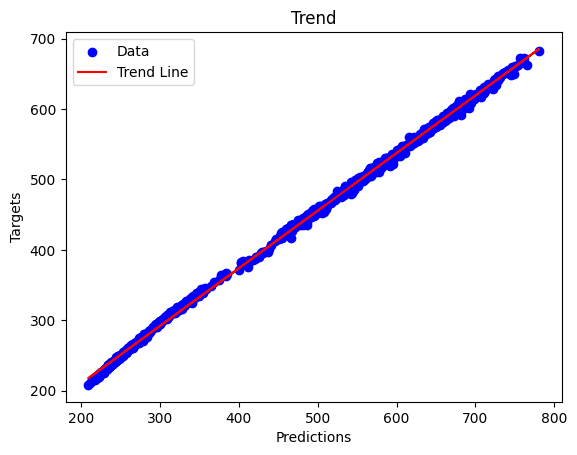

In [178]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    np.savetxt(file, preds, delimiter=',', fmt='%d', header='pred,target', comments='')

model = Stock_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
save_pred(preds, 'pred.csv')
plot_error_rate(preds[:,0], preds[:,1])
plot_pred(preds[:,0], preds[:,1])
plot_trend(preds[:,0], preds[:,1])

In [179]:
model = Stock_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))

single_loader = stock_dataloader(config, [[100,110,90,101]], [103])
predict(single_loader, model, device)

# for pred, target in single_pred:
#     print(f"Prediction: {pred}, Target: {target}")

100%|██████████| 1/1 [00:00<00:00, 497.49it/s]


array([[114.989006, 103.      ]], dtype=float32)